# Matriz Getis Ord Brasil

Para fazer commit: `Ctrl + Shift + m`   
Reposotório: `spatial_cluster`   
Caminho do arquivo: `scripts/sul/matriz_getis_ord_brasil.ipynb`

## Bibliotecas

In [2]:
!pip install geopandas==0.8.1
!pip install --upgrade pyshp
!pip install shapely==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install jenkspy
!pip install pyshp

     |████████████████████████████████| 962 kB 5.3 MB/s 
     |████████████████████████████████| 16.7 MB 35.2 MB/s 
     |████████████████████████████████| 6.3 MB 46.1 MB/s 
     |████████████████████████████████| 44 kB 1.6 MB/s 
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.8.1.post1
    Uninstalling Shapely-1.8.1.post1:
      Successfully uninstalled Shapely-1.8.1.post1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 2.4 MB 8.0 MB/s 
     |████████████████████████████████| 95 kB 3.3 MB/s 
     |████████████████████████████████| 209 kB 57.4 MB/s 
     |████████████████████████████████| 60 kB 6.5 MB/s 
     |█████████████████████████████

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import scipy.stats as stats
import jenkspy

# para a análise de dados espaciais
import geopandas
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# para gráficos
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches, colors
from matplotlib.lines import Line2D
from matplotlib.collections import EventCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection  
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# para agrupamento - K-médias
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore")

import shapefile
from google.colab import drive, files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


# Dados

In [6]:
link = 'https://raw.githubusercontent.com/walefmachado/spreg_rural_insurance/main/dados/'

### Dados de seguro rural

In [7]:
dados_br = pd.read_csv(link+'/dados_06_19.csv')

### Dados para espacial 

In [8]:
cod = pd.read_csv(link+'/codigos-mun.csv')

In [9]:
br = geopandas.read_file(link+'/br.json')

In [10]:
br = br.rename(columns={'CD_GEOCMU': 'mun'})
br.mun = br.mun.astype(int)
br2 = br.drop('NM_MUNICIP', axis=1)

In [11]:
cod_dados = cod.merge(br2, how='left')
cod_dados = geopandas.GeoDataFrame(cod_dados) # Ate aqui junta geometry com todos os códigos 

In [12]:
dados_br = cod_dados.merge(dados_br, on='mun', how='left')

In [13]:
dados_br = dados_br.fillna(0)
#dados_br = dados_br.drop([1525, 3499]) # retira F. Noronha e Ilhabela
dados_br = dados_br.drop(['rm'], axis = 1)

In [14]:
dados_br.rename(columns = {'nome_mun_x': 'nome_mun', 'nome_meso_x':'nome_meso'}, inplace = True)

In [15]:
retirar = ['nome_mun_y', 'nome_meso_y']
dados_br = dados_br.drop(retirar, axis = 1)

In [16]:
img=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_3.png')
img2=mpimg.imread('/content/drive/My Drive/Mestrado/Imagens/rosa_dos_ventos_p.png')

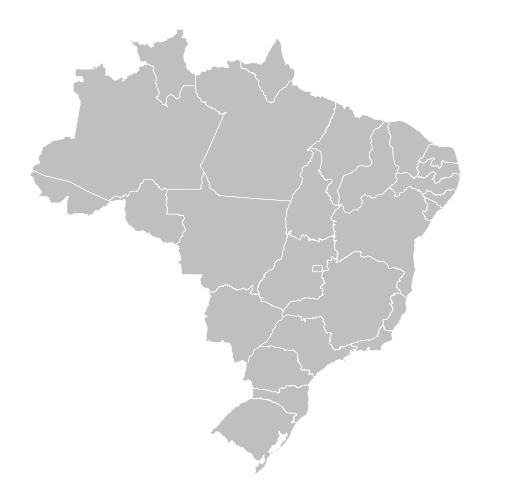

In [17]:
#Regioes geograficas
sf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
Nshp = len(shapes)

ptchs   = []
for nshp in range(Nshp):
    pts     = np.array(shapes[nshp].points)
    prt     = shapes[nshp].parts
    par     = list(prt) + [pts.shape[0]]

    for pij in range(len(prt)):
       ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))

#UF
sf_uf = shapefile.Reader('/content/drive/My Drive/Mestrado/Dados/estados/estados_2010.shp')
shapes = sf.shapes()
shapes_uf = sf_uf.shapes()
Nshp_uf = len(shapes_uf)

ptchs_uf   = []
for nshp_uf in range(Nshp_uf):
    pts_uf     = np.array(shapes_uf[nshp_uf].points)
    prt_uf     = shapes_uf[nshp_uf].parts
    par_uf     = list(prt_uf) + [pts_uf.shape[0]]

    for pij_uf in range(len(prt_uf)):
       ptchs_uf.append(Polygon(pts_uf[par_uf[pij_uf]:par_uf[pij_uf+1]]))


fig     = plt.figure(figsize = (9,9))
ax      = fig.add_subplot(111)

ax.add_collection(PatchCollection(ptchs,facecolor='0.75', edgecolor='w', linewidths=0))
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))
ax.axis('auto'); ax.axis('off')
plt.show()
# Fonte: http://www.phme.it/wilt/2017/05/06/dynamic-mapping-with-shapefiles-and-python/

In [18]:
#dados_br[dados_br['ano']==2019].plot(column='apolices_contratadas', figsize=(10, 10), cmap='viridis', scheme='quantiles')

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
dados_br[dados_br['ano']==2019].plot(column='apolices_contratadas', ax=ax, cmap='viridis', scheme='quantiles', legend=True)
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.4))
ax.set_axis_off()
plt.figimage(img2, 720, 25, zorder=1)
plt.show();

In [19]:
variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil',
             'total_subvencao_mil', 'valor_indenizacoes_pagas_mil',
             'sinistralidade_media', 'taxa_media', 'apolices_indenizadas'] # 
anos = dados_br.ano.unique()

In [20]:
dados_br = dados_br.rename({'apolices_contratadas':'TAC',
                            'total_segurado_mil':'SIS',
                            'soma_premio_total_mil':'SPR',
                            'total_subvencao_mil':'TSB',
                            'valor_indenizacoes_pagas_mil':'SIP',
                            'taxa_media':'TMA',
                            'apolices_indenizadas':'NAI'}, axis=1)
#variaveis = ['apolices_contratadas', 'total_segurado_mil', 'soma_premio_total_mil', 'total_subvencao_mil', 'valor_indenizacoes_pagas_mil', 'taxa_media', 'apolices_indenizadas']
variaveis = ['TAC', 'SIS', 'SPR', 'TSB', 'SIP', 'TMA', 'NAI']

In [21]:
dados_19 = dados_br[dados_br['ano']==2019]
dados_19.drop('ano', axis=1, inplace=True)

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20)) 
db = geopandas.GeoDataFrame(dados_19)
axs = axs.flatten()
for i, variavel in enumerate(variaveis):
    ax = axs[i]
    #y = dados_19[variavel].values 
    #g_loc_br = G_Local(y, w)
    #g_map(g_loc_br, dados_19, ax=ax)
    dados_19.plot(column=variavel, ax=ax, cmap='viridis', scheme='quantiles', legend=True)
    ax.set_axis_off()
    ax.set_title(variavel, fontsize=25)
    f.tight_layout() 
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
axs[7].set_axis_off()
axs[8].set_axis_off()
axs[7].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.0005, hspace=0.001)
plt.show();

## Matriz de G de Getis-Ord


Teste de construção de uma matriz de G de Getis-Ord para cada variável


### Criando a matriz

### G de Getis-Ord local para variáveis

In [22]:
dados_19.drop(index=dados_19[dados_19['mun'] == 2605459].index, inplace=True) # retira F. Noronha e Ilhabela
dados_19.drop(index=dados_19[dados_19['mun'] == 3520400].index, inplace=True) 

In [23]:
getis_matrix = dados_19

In [24]:
retirar = ['uf', 'nome_uf', 'mun', 'meso', 'nome_meso', 
           'micro', 'nome_micro', 'codmun6', 'regiao', 
           'nome_regiao', 'cod_uf','sinistralidade_media'] # , 'geometry'
getis_matrix = getis_matrix.drop(retirar, axis = 1)

In [25]:
# demora um pouco
w = Queen.from_dataframe(dados_19)
w.transform = 'r'

In [26]:
for variavel in getis_matrix.drop(['nome_mun', 'geometry'], axis = 1).columns:
    getis_matrix[variavel] = G_Local(dados_19[variavel].values, w).Zs

In [27]:
getis_matrix = getis_matrix.set_index('nome_mun')

In [28]:
getis_matrix.describe().round(2)

,TAC,SIS,SPR,TSB,SIP,TMA,NAI
count,5568.00,5568.00,5568.00,5568.00,5568.00,5568.00,5568.00
mean,0.05,0.06,0.05,0.05,0.04,0.05,0.03
std,0.88,0.83,0.82,0.82,0.74,0.95,0.81
min,-0.29,-0.30,-0.27,-0.27,-0.22,-0.40,-0.22
25%,-0.29,-0.30,-0.27,-0.27,-0.22,-0.40,-0.22
50%,-0.27,-0.28,-0.26,-0.26,-0.22,-0.36,-0.22
75%,-0.07,0.00,-0.05,-0.05,-0.11,-0.03,-0.15
max,12.57,8.27,10.53,10.22,9.92,8.52,9.52


### Mapa G de Getis-Ord

In [ ]:
def g_map(g, geog, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='lightgrey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='#fde725', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='#3b528b', edgecolor=ec, linewidth=0.1)
    # Style and draw

    st = ''
    if g.star:
        st = '*'
    #ax.set_title(f'G{st} statistic for Pct of Leave votes', size=15)
    ax.set_axis_off()
    return ax

In [ ]:
# cria a legenda G loca
labels_g = ['Hot spot', 'Cool spot', 'não significativo']
color_list_g = ["#fde725", "#3b528b", "lightgrey"]
hmap_g = colors.ListedColormap("", color_list_g)
lines_g= [Line2D([0], [0], color=c, marker='o', markersize=25, linestyle='') for c in color_list_g] # linewidth=20, linestyle='dotted'

In [ ]:
#y = dados_19['TAC'].values 
#g_loc_br = G_Local(y, w)
#db = dados_19
#f, axs = plt.subplots(1, 2, figsize=(12, 6))
#axs = axs.flatten()
#g_map(g_loc_br, db, ax=axs[0])
#plt.show()

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20)) 
db = geopandas.GeoDataFrame(dados_19)
axs = axs.flatten()
for i, variavel in enumerate(variaveis):
    ax = axs[i]
    y = dados_19[variavel].values 
    g_loc_br = G_Local(y, w)
    g_map(g_loc_br, dados_19, ax=ax)
    #moran_matrix.plot(column=variavel, ax=ax, legend=True, scheme='quantiles', cmap = 'viridis'); # , cmap='OrRd'  scheme='quantiles',
    ax.set_axis_off()
    ax.set_title(variavel, fontsize=25)
    f.tight_layout() 
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual
axs[7].legend(lines_g, labels_g, loc='botton left', bbox_to_anchor=(1.7, 0.75), frameon=False,  prop={'size': 20})
axs[7].set_axis_off()
axs[8].set_axis_off()
axs[7].imshow(img)
plt.subplots_adjust(left=7, bottom=7, right=8, top=8, wspace=0.0005, hspace=0.001)
plt.show();

In [ ]:
f, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 15)) 
axs = axs.flatten()
for i, variavel in enumerate(variaveis):
    ax = axs[i] 
    getis_matrix.plot(column=variavel, ax=ax, legend=True, scheme='quantiles', cmap = 'viridis'); # , cmap='OrRd'  scheme='quantiles',
    ax.set_axis_off()
    ax.set_title(variavel, fontsize=20)
    f.tight_layout() 
    ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.5))   # adiciona a divisão estadual

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
getis_matrix.plot(column='apolices_contratadas', ax=ax,  figsize=(10, 10), legend=True, scheme='quantiles', cmap = 'viridis'); # , cmap='OrRd'  scheme='quantiles',
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
ax.set_axis_off()
plt.figimage(img2, 720, 25, zorder=1)
plt.show();

## Análise de agrupamento - G de Getis-Ord

In [29]:
# subselecionar variáveis
X = getis_matrix.drop('geometry', axis=1)
# transformar em matriz (necessário para gerar o gráfico)
XX = X.values
# mudar o tipo dos dados
XX = np.asarray(XX, dtype=float)
n = XX.shape[0]
p = XX.shape[1]
# vetor de médias
Xb = np.mean(XX, axis=0)
# matriz de covariâncias
S = np.cov(XX.T)
# matriz de somas de quadrados e produtos
W = (n - 1) * S

In [30]:
Z = linkage(X, method='ward')

In [31]:
max_d = 0
grupos = cut_tree(Z, height=max_d)

In [32]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(3000)

1000


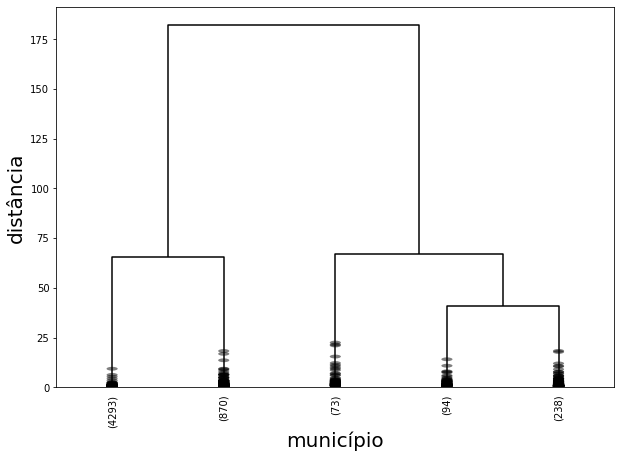

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))
ax = dendrogram(
    Z,
    truncate_mode='lastp',  # mostrar apenas os p últimos grupos formados
    p=5,  # quantos passos mostrar
    show_leaf_counts=True,  # mostrar quantas observações há em cada grupo entre parênteses
    leaf_rotation=90., # rotação
    leaf_font_size=10., # tamanho da fonte
    labels=dados_19.index, # rótulos do eixo x
    show_contracted=True,  # to get a distribution impression in truncated branches,
    above_threshold_color='black',
    color_threshold=0.1, # para que todas as linhas sejam da mesma cor
    # color_threshold=max_d, # para que os grupos fiquem com cores diferentes
)
plt.axhline(y=max_d, c='grey', lw=1, linestyle='dashed')
plt.xlabel('município', fontsize = 20)
plt.ylabel('distância', fontsize = 20);

**Método escolhido:** 

In [34]:
# definir a distância de corte baseando no dendrograma
max_d = 55
grupos = cut_tree(Z, height=max_d)

### Métricas

In [35]:
# incluir no dataframe de dados as informações sobre a qual grupo cada observação pertence
getis_matrix['grupo'] = grupos
# moran_matrix.head(2)

In [36]:
dados_19['grupo'] = grupos

In [37]:
pd.options.display.float_format = '{:20,.2f}'.format

In [38]:
dados_19.groupby('grupo').mean().round(2).drop(['cod_uf', 'mun', 'meso', 'micro', 'codmun6', 'regiao', 'sinistralidade_media'], axis=1)#.to_latex()

,TAC,SIS,SPR,TSB,SIP,TMA,NAI
grupo,,,,,,,
0,2.03,"575,862.61","26,371.01","9,127.21","6,397.54",0.05,0.11
1,31.34,"8,223,079.03","467,073.47","161,725.15","121,009.70",0.53,2.53
2,131.03,"22,334,516.01","1,570,846.99","545,795.72","465,570.70",1.82,14.83
3,210.66,"41,553,730.58","3,055,409.76","1,066,913.45","700,965.69",1.99,20.14


In [39]:
# contagem de observações em cada grupo
getis_matrix.grupo.value_counts()

0    4293
1     870
2     332
3      73
Name: grupo, dtype: int64

In [40]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix.groupby('grupo').mean().round(2).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &                  TAC &                  SIS &                  SPR &                  TSB &                  SIP &                  TMA &                  NAI \\\\\ngrupo &                      &                      &                      &                      &                      &                      &                      \\\\\n\\midrule\n0     &                -0.25 &                -0.25 &                -0.24 &                -0.24 &                -0.19 &                -0.31 &                -0.20 \\\\\n1     &                 0.34 &                 0.56 &                 0.42 &                 0.42 &                 0.31 &                 0.54 &                 0.18 \\\\\n2     &                 2.19 &                 1.82 &                 1.80 &                 1.81 &                 1.57 &                 2.63 &                 2.04 \\\\\n3     &                 4.29 &                 4.56 &                 4.90 &           

In [41]:
# mediana das variáveis para cada grupo
getis_matrix.groupby('grupo').median()

,TAC,SIS,SPR,TSB,SIP,TMA,NAI
grupo,,,,,,,
0,-0.28,-0.30,-0.27,-0.27,-0.22,-0.39,-0.22
1,0.24,0.45,0.32,0.32,0.15,0.32,0.01
2,1.97,1.68,1.75,1.77,1.33,2.53,1.77
3,3.86,4.30,4.37,4.41,2.77,3.15,2.28


### As observações de cada grupo

In [42]:
#grupo0 = dados.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos G de Getis Ord

In [43]:
getis_matrix['grupo'] = getis_matrix['grupo'].astype('category')

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
getis_matrix.plot(column='grupo', figsize=(10, 10), legend=True, ax=ax, cmap='viridis'); # , cmap='OrRd'ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
ax.set_axis_off()
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
plt.figimage(img2, 720, 25, zorder=1)
plt.show();

## K-Médias - G de Getis-Ord

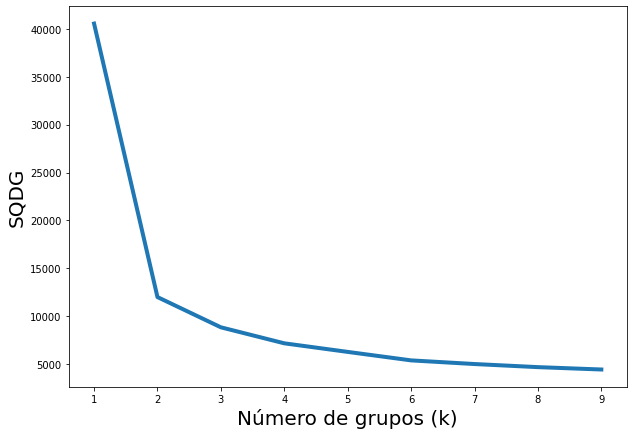

In [ ]:
# SQDG
SQDG = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(getis_matrix.drop('geometry', axis=1))
    getis_matrix['grupos'] = kmeans.labels_
    SQDG[k] = kmeans.inertia_ # Inertia: soma das distâncias das obs. ao centro mais próximo
plt.figure(figsize=(10, 7))
plt.plot(list(SQDG.keys()), list(SQDG.values()), linewidth=4)
plt.xlabel('Número de grupos (k)', fontsize = 20)
plt.ylabel('SQDG', fontsize = 20);

In [41]:
k = 4

In [42]:
kmeans = KMeans(n_clusters=k, random_state=10).fit(X)

In [43]:
# incluir no resultado dos escores dos dois primeiros CPs a informação sobre os grupos obtidos 
# com o método das k-médias
getis_matrix['grupo'] = kmeans.labels_

In [44]:
dados_19['grupo'] = kmeans.labels_

In [46]:
dados_19.groupby('grupo').mean().round(2).drop(['cod_uf', 'mun', 'meso', 'micro', 'codmun6', 'regiao', 'sinistralidade_media'], axis=1).to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &                  TAC &                  SIS &                  SPR &                  TSB &                  SIP &                  TMA &                  NAI \\\\\ngrupo &                      &                      &                      &                      &                      &                      &                      \\\\\n\\midrule\n0     &                 2.86 &           841,211.68 &            38,991.52 &            13,541.56 &            10,018.64 &                 0.06 &                 0.17 \\\\\n1     &                38.21 &         9,766,021.38 &           566,793.66 &           196,009.24 &           152,086.38 &                 0.64 &                 3.39 \\\\\n2     &               226.97 &        40,993,363.61 &         2,967,590.76 &         1,037,155.87 &           678,955.97 &                 2.22 &                21.02 \\\\\n3     &               124.95 &        20,869,352.28 &         1,529,173.71 &           

In [ ]:
# contagens
getis_matrix.grupo.value_counts()

0    4516
1     680
3     279
2      93
Name: grupo, dtype: int64

In [ ]:
# incluir no dataframe de dados as informações sobre a qual grupo cada município pertence
# dados['grupo'] = kmeans.labels_

In [ ]:
# média dos grupos - todas as variáveis
# inclusive as não utilizadas para agrupar
getis_matrix.groupby('grupo').mean().to_latex()

'\\begin{tabular}{lrrrrrrr}\n\\toprule\n{} &                  TAC &                  SIS &                  SPR &                  TSB &                  SIP &                  TMA &                  NAI \\\\\ngrupo &                      &                      &                      &                      &                      &                      &                      \\\\\n\\midrule\n0     &                -0.23 &                -0.23 &                -0.22 &                -0.22 &                -0.18 &                -0.29 &                -0.19 \\\\\n1     &                 0.47 &                 0.73 &                 0.57 &                 0.57 &                 0.40 &                 0.72 &                 0.27 \\\\\n2     &                 4.43 &                 4.22 &                 4.40 &                 4.41 &                 3.61 &                 3.65 &                 3.60 \\\\\n3     &                 2.14 &                 1.74 &                 1.81 &           

In [ ]:
pd.options.display.float_format = '{:20,.2f}'.format
resumo_estatistico = getis_matrix.groupby('grupo').mean()
print(resumo_estatistico.to_latex(index=True))  

\begin{tabular}{lrrrrrrr}
\toprule
{} &                  TAC &                  SIS &                  SPR &                  TSB &                  SIP &                  TMA &                  NAI \\
grupo &                      &                      &                      &                      &                      &                      &                      \\
\midrule
0     &                -0.23 &                -0.23 &                -0.22 &                -0.22 &                -0.18 &                -0.29 &                -0.19 \\
1     &                 0.47 &                 0.73 &                 0.57 &                 0.57 &                 0.40 &                 0.72 &                 0.27 \\
2     &                 4.43 &                 4.22 &                 4.40 &                 4.41 &                 3.61 &                 3.65 &                 3.60 \\
3     &                 2.14 &                 1.74 &                 1.81 &                 1.81 &          

In [ ]:
# mediana das variáveis para cada grupo
getis_matrix.groupby('grupo').median()

In [ ]:
#grupo0 = mg.query('grupo == 0').index
#list(grupo0)

### Mapa Grupos com G de Getis Ord 

In [ ]:
getis_matrix['grupo'] = getis_matrix['grupo'].astype('category')

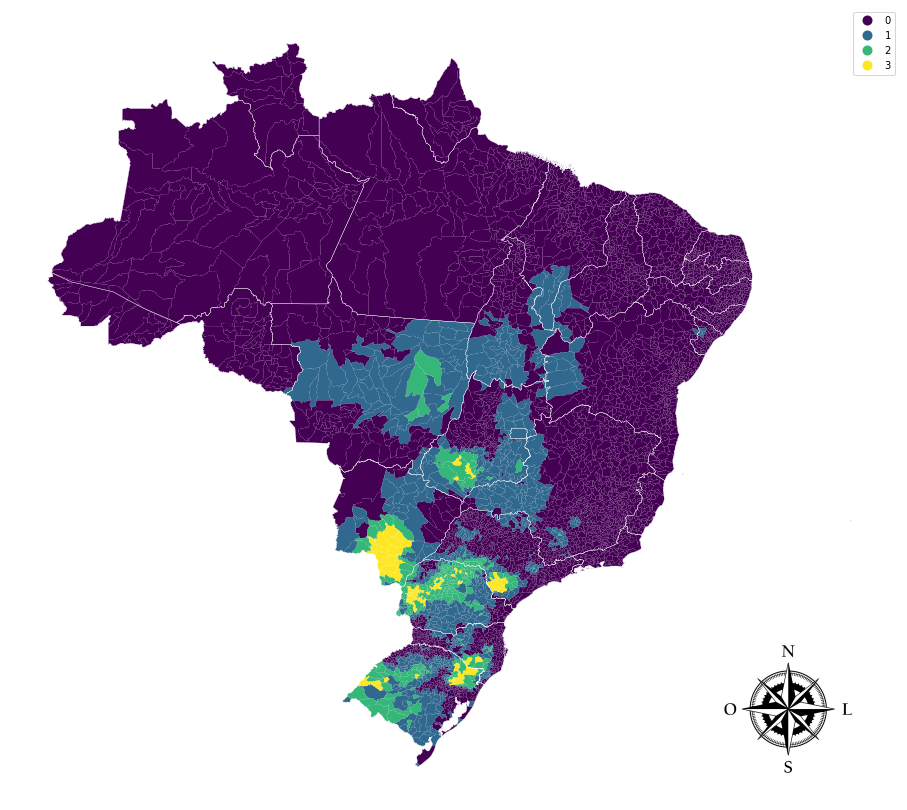

In [ ]:
f, ax = plt.subplots(figsize=(16,16)) # 
getis_matrix.plot(column='grupo', figsize=(10, 10), legend=True, ax=ax, cmap='viridis'); # , cmap='OrRd'ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
ax.set_axis_off()
ax.add_collection(PatchCollection(ptchs_uf,color='none', edgecolor='w', linewidths=0.3))
plt.figimage(img2, 720, 25, zorder=1)
plt.show();

## KDE plot

In [ ]:
getis_matrix.columns

Index(['cod_uf', 'geometry', 'apolices_contratadas', 'total_segurado_mil',
       'soma_premio_total_mil', 'total_subvencao_mil',
       'valor_indenizacoes_pagas_mil', 'sinistralidade_media', 'taxa_media',
       'apolices_indenizadas', 'grupo', 'grupos'],
      dtype='object')

In [ ]:
dados_plots = getis_matrix.drop(['geometry', 'grupos'], axis = 1)

In [ ]:
dados_plots.shape

(5568, 10)

In [ ]:
dados_plots.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5568 entries, Alta Floresta D'Oeste to Brasília
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   cod_uf                        5568 non-null   float64 
 1   apolices_contratadas          5568 non-null   float64 
 2   total_segurado_mil            5568 non-null   float64 
 3   soma_premio_total_mil         5568 non-null   float64 
 4   total_subvencao_mil           5568 non-null   float64 
 5   valor_indenizacoes_pagas_mil  5568 non-null   float64 
 6   sinistralidade_media          5568 non-null   float64 
 7   taxa_media                    5568 non-null   float64 
 8   apolices_indenizadas          5568 non-null   float64 
 9   grupo                         5568 non-null   category
dtypes: category(1), float64(9)
memory usage: 440.5+ KB


In [ ]:
tidy_db = dados_plots.set_index('grupo')
# Keep only variables used for clustering
#tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Variável', 
                        0: 'Valores'})
# Check out result
tidy_db.head()

,grupo,Variável,Valores
0,0,cod_uf,-2.174978
1,0,apolices_contratadas,-0.282022
2,0,total_segurado_mil,-0.299054
3,0,soma_premio_total_mil,-0.268429
4,0,total_subvencao_mil,-0.268848


In [ ]:
import seaborn

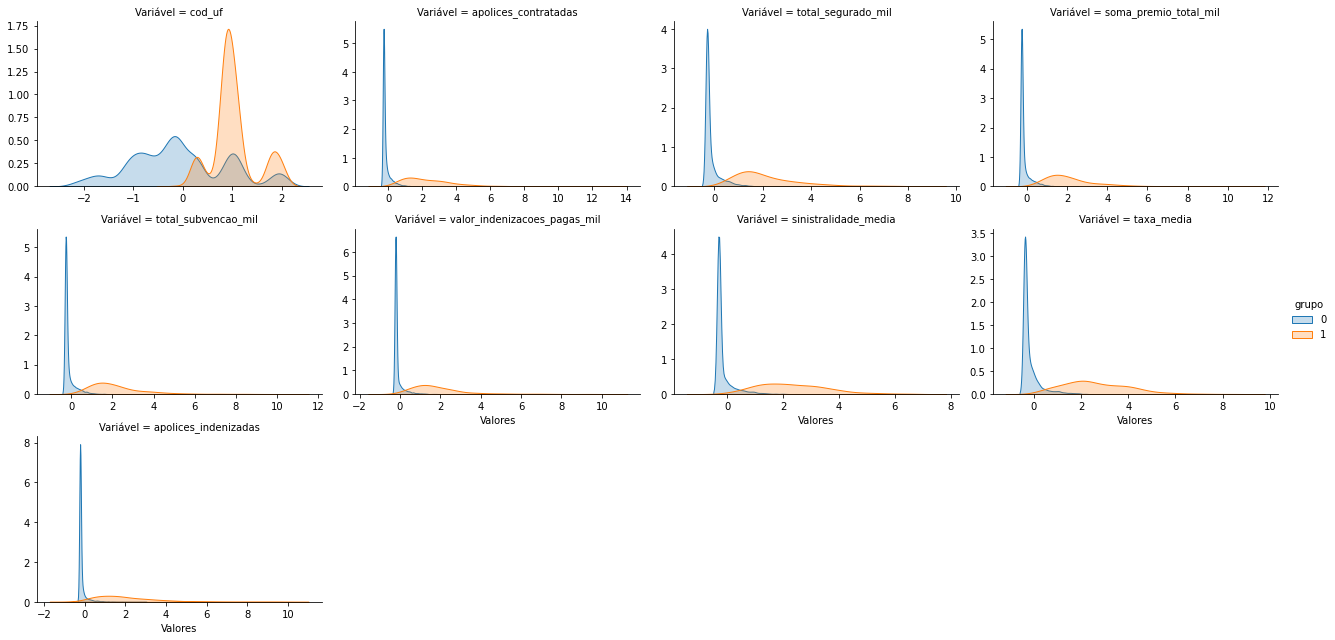

In [ ]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Variável', hue='grupo', \
                  sharey=False, sharex=False, aspect=1.5, col_wrap=4)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Valores', shade=True).add_legend()